# Port loading exploratory analysis

A high-level analysis of this data gives several headline insights relating to the operation, utilisation and relationships between ports in the UK at a macro level. Port loading can be explored by plotting the average number of visits per day and the average vessel size per visit. 

In [1]:
# base libraries
import numpy as np
import pandas as pd
import datetime
import os
import json
import matplotlib.pyplot as plt

In [2]:
# set variable from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

cers_path = config['DEFAULT']['cers_path']
cers_filename = config['DEFAULT']['cers_filename']
port_filename = config['DEFAULT']['port_filename']
vessel_filename = config['DEFAULT']['vessel_filename']

### Data Import and merge

In [3]:
cers = pd.read_csv(cers_path+cers_filename,header = 0,delimiter = ',')
cers['ETA'] = pd.to_datetime(cers["ETA"])
cers['ETA_date'] = cers['ETA'].dt.date
cers.drop_duplicates(keep = 'last',inplace = True)
cers = cers[cers.MMSI != -1]

ports = pd.read_csv(cers_path+port_filename,header = 0,delimiter = ',')
ports.drop_duplicates(keep = 'last',inplace = True)

vessels = pd.read_csv(cers_path+vessel_filename,header = 0,delimiter = ',')
vessels.drop_duplicates(keep = 'last',inplace = True)

In [4]:
cers = cers.merge(ports[['LOCODE','Name']], how = 'left', left_on = 'POC_LOCODE', right_on = 'LOCODE')
cers = cers.merge(vessels[['MMSI','Gross Tonnage']], how = 'left', on = 'MMSI')

### Average number of visits per day
Here it can be seen that there are a handful of ports that receive very large volumes of visits per day. The large number of daily visits to both Portsmouth and Southampton ports reflect their status amongst the largest passenger ports in the UK; this is further reflected in the relatively low average vessel size per visit. Surprisingly Felixstowe, the largest freight container port in the UK, has a comparatively low number of daily visits.

In [5]:
cers_arrivals = cers.groupby(['Name','ETA_date'])['voyage_id'].count()

In [6]:
cers_arrivals = cers_arrivals.groupby(['Name']).mean()
cers_arrivals = cers_arrivals.sort_values(ascending = False)

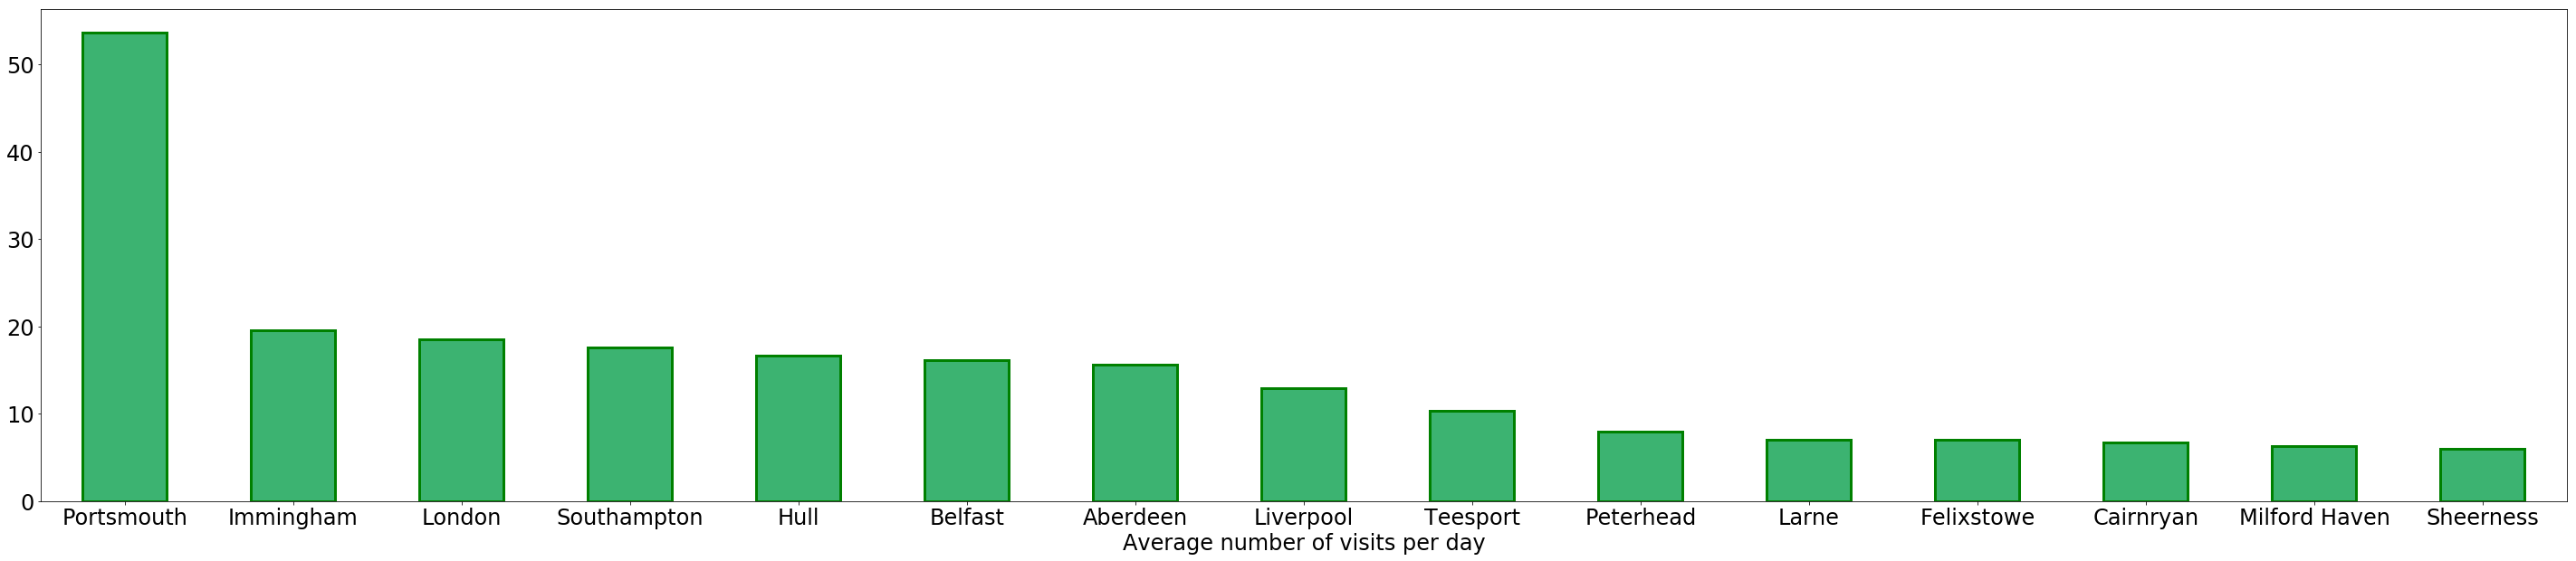

In [7]:
plt.figure(figsize=(50,10))
cers_arrivals.iloc[:15].plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=3)
plt.xlabel('Average number of visits per day',fontsize=24)
plt.xticks(fontsize=24,rotation=0)
plt.yticks(fontsize=24)
plt.show()

### Average vessel size per visit (tonnes)
Turning to the average vessel size per visit. The first fours ports (Shetland, Hound Point, Tetney and Orkney) are all ports that predominantly serve the gas and petrochemical industries and are therefore most likely to be visited by the very large super tankers. Of the non-petrol chemical related ports, Felixstowe receives the largest ships by gross tonnage.

In [8]:
cers_size = cers.groupby(['Name'])['Gross Tonnage'].mean()
cers_size = cers_size.sort_values(ascending = False)

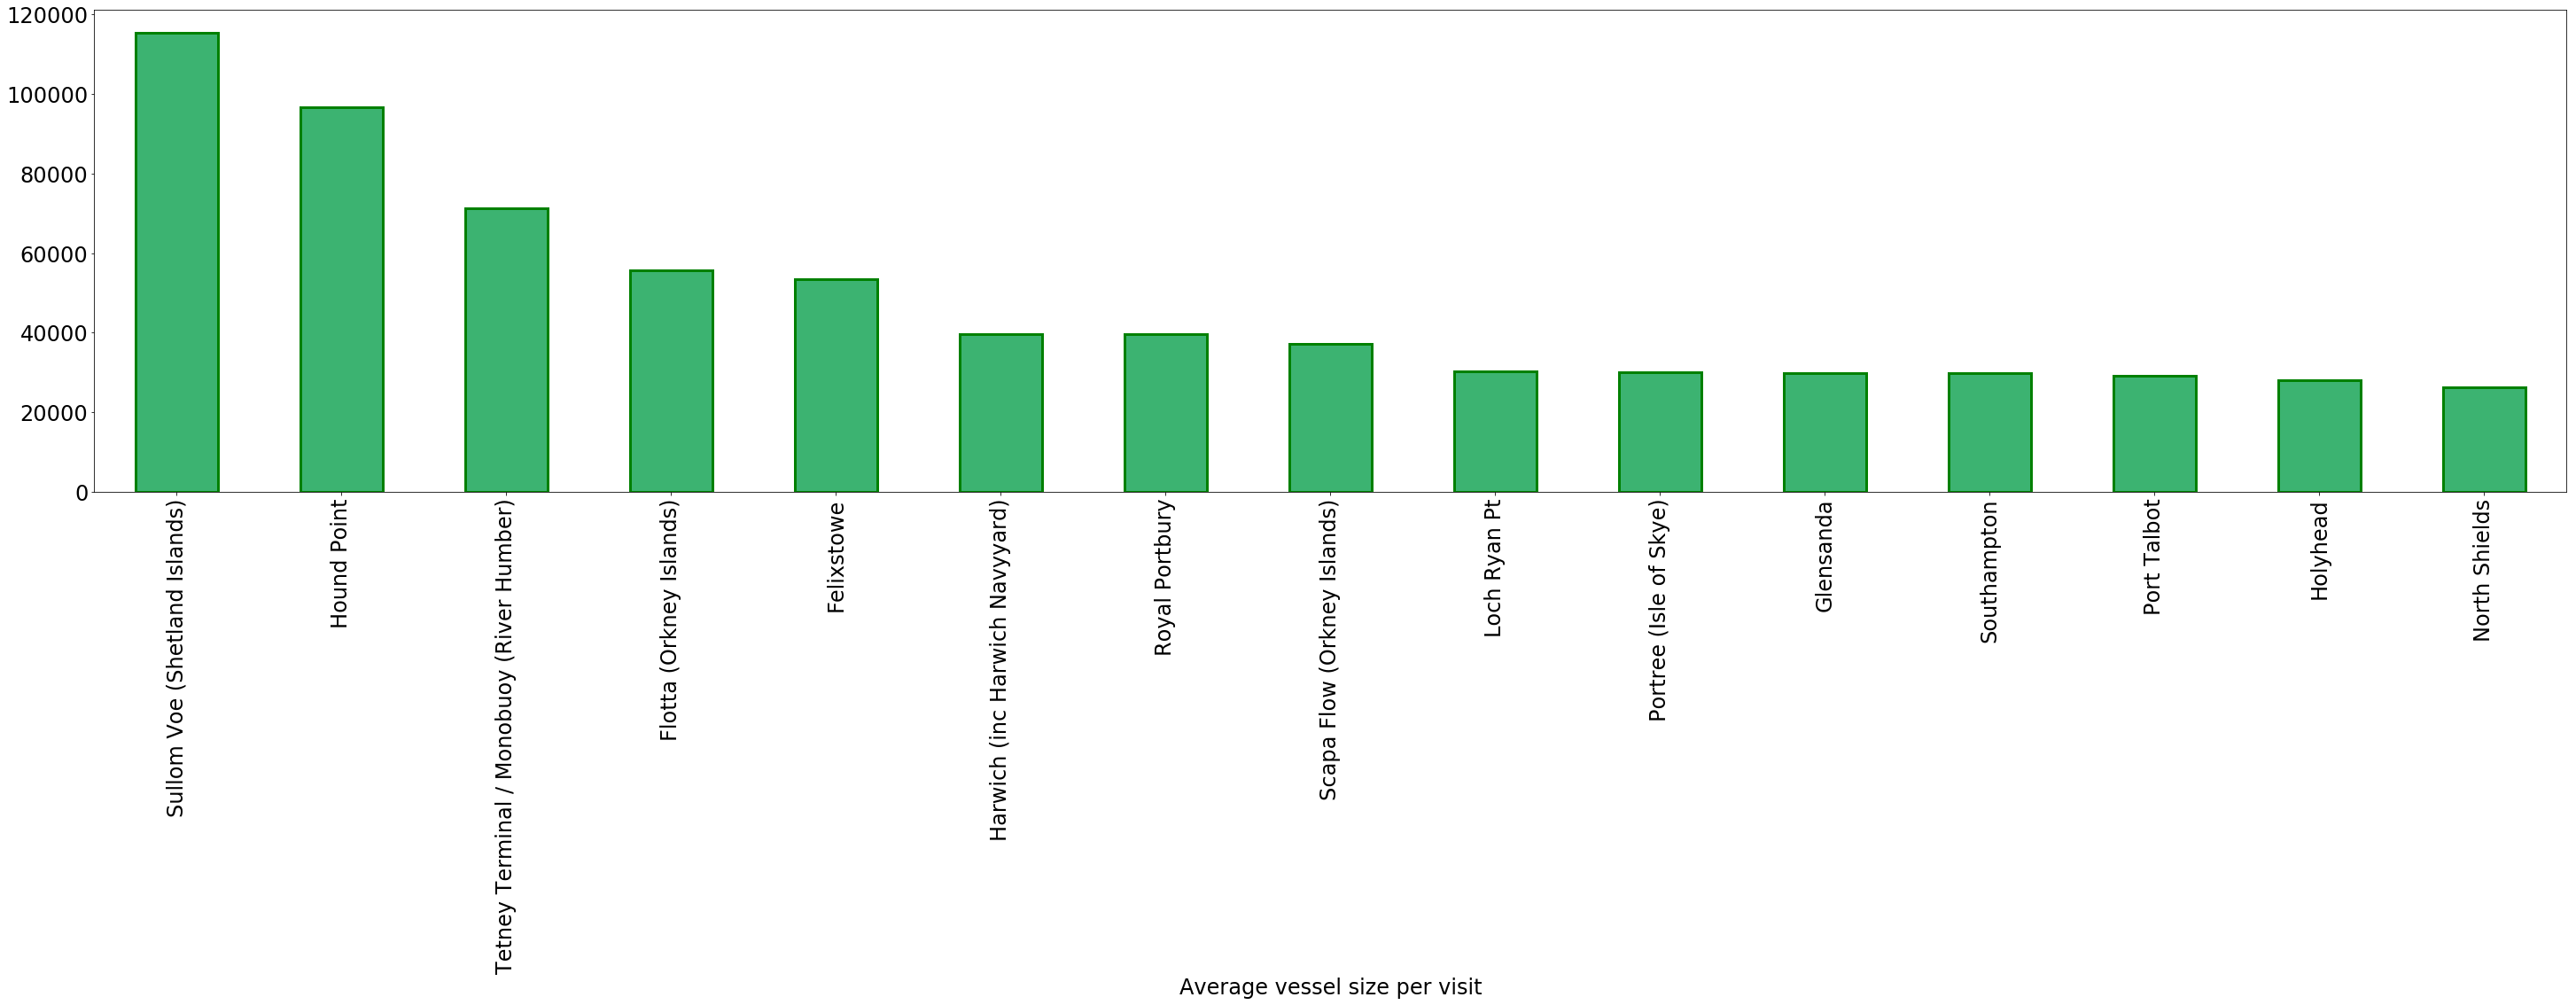

In [9]:
plt.figure(figsize=(50,10))
cers_size.iloc[:15].plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=3)
plt.xlabel('Average vessel size per visit',fontsize=24)
plt.xticks(fontsize=24,rotation=90)
plt.yticks(fontsize=24)
plt.show()

### Monthly arrivals at Felixstowe

The figures are expressed as indices relative to the expected average for that time window. For instance, a daily value of 1.2 indicates arrivals that are 20% higher than the expected daily average. The indices for monthly arrivals are very small and caution must be exercised, however they suggest there may be a small seasonal trend with fewer than expected ships docking at Felixstowe over the winter months (September to February) and larger volumes over the summer months (May to August). 

In [10]:
felix = cers[cers.Name == 'Felixstowe'].copy()
felix['MOY'] = felix['ETA'].dt.month

In [11]:
def create_index(df,var):
    ''' 
    Creates an index for the selected variable by summarising the data to each class of the variable and
    dividing by the average class value
    Parameters
      df: a dataframe containing the variable to be indexed
      var: the variable to be indexed
    Returns a series containing the index for variable
    '''
    
    df = df.groupby(var)['voyage_id'].count()
    
    month_avg = df.mean()
    
    df = df/month_avg
    
    return df

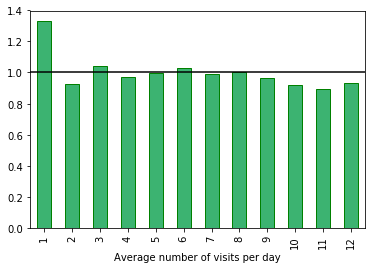

In [12]:
# plot the monthly arrivals expressed as an index relative the the monthly average taken across the year
felix_moy = create_index(felix,'MOY')
felix_moy.plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=1)
plt.xlabel('Average number of visits per day')
plt.axhline(y=1, color = 'black')
plt.show()

### Daily arrivals at Felixstowe

Turning to the daily breakdown, arrivals into port are lower over the weekend and higher during the working week. One exception to this is Monday where arrivals are almost 20% lower than the expected daily average. 

In [13]:
felix['DOW'] = felix['ETA'].dt.weekday + 1

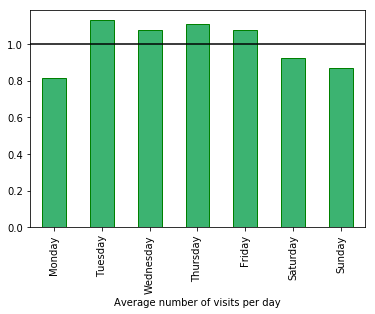

In [14]:
felix_dow = create_index(felix,'DOW')
ax = felix_dow.plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=1)
plt.xlabel('Average number of visits per day')
plt.axhline(y=1, color = 'black')
ax.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

### Arrivals at Felixstowe throughout the day

A stronger message can be seen when arrivals are broken down by time of the day, here Felixstowe has at least 20% fewer than average arrivals between early morning and lunchtime hours (0400 to 1300), with the quietest period generally being between 0800-0900 where arrivals are over 40% less than expected. Afternoons and evenings are generally much busier (1300-2200) with arrivals being up to 30% more than average.

In [15]:
felix['HOD'] = felix['ETA'].dt.hour + 1
bins = [0,4,8,9,11,13,17,22,24]
groups = ['22:00 - 04:00','04:00 - 08:00','08:00 - 09:00','09:00 - 11:00','11:00 - 13:00','13:00 - 17:00','17:00 - 22:00','22:00 - 4:00']
felix['time_period'] = pd.cut(felix['HOD'], bins, labels=groups)
felix['time_period'] = felix['time_period'].str.replace('22:00 - 4:00','22:00 - 04:00')

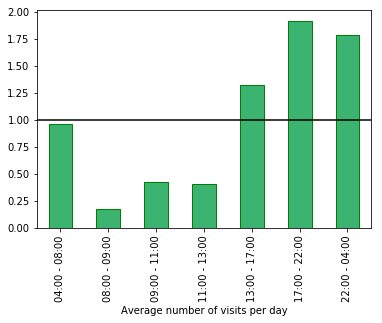

In [16]:
felix_hod = create_index(felix,'time_period')
felix_hod.plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=1)
plt.xlabel('Average number of visits per day')
plt.axhline(y=1,color = 'black')
plt.show()